In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.python.keras.utils import conv_utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle


from random import randint, seed
import itertools
import cv2

## Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Codes are mainly from : [Partial Convolution Keras](https://github.com/MathiasGruber/PConv-Keras)


#### Purpose :

#### 1. Testing some properties about texture & content synthesis for image inpainting task

#### 2. This notebook trains 2 models to test the idea from [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022)

#### 3. And further do some experiment about difference between In and Bn, better understanding the idea from  [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) and [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)

# Model

## Partial Convolution

In [ ]:
class PConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4), tf.keras.layers.InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        space = input_shape[0][1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding='same',
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
        return [new_shape, new_shape]

## Instance Normalization

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

## Generator UNET

In [ ]:
    def generator(norm_type='Bn',train=True):

        # INPUTS
        inputs_img = tf.keras.layers.Input((None, None, 3), name='inputs_img')
        inputs_mask = tf.keras.layers.Input((None, None, 3), name='inputs_mask')


        def encoder_layer(img_in, mask_in, filters, kernel_size,norm_type,norm=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if norm:
                if norm_type=='In':
                    conv=InstanceNormalization()(conv)
                else:
                    conv=tf.keras.layers.BatchNormalization()(conv,training=train)

            conv = tf.keras.layers.ReLU()(conv)
            return conv, mask


        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, norm_type,norm=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5,norm_type)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5,norm_type)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3,norm_type)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3,norm_type)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3,norm_type)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3,norm_type)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3,norm_type)


        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size,norm_type, norm=True):
            up_img = tf.keras.layers.UpSampling2D(size=(2, 2))(img_in)
            up_mask = tf.keras.layers.UpSampling2D(size=(2, 2))(mask_in)
            concat_img = tf.keras.layers.Concatenate(axis=-1)([e_conv, up_img])
            concat_mask = tf.keras.layers.Concatenate(axis=-1)([e_mask, up_mask])

            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])

            if norm:
                if norm_type=='In':
                    conv=InstanceNormalization()(conv)
                else:
                    conv=tf.keras.layers.BatchNormalization()(conv,training=train)
            conv = tf.keras.layers.LeakyReLU(alpha=0.2)(conv)
            return conv, mask

        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3,norm_type)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3,norm_type)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3,norm_type)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3,norm_type)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3,norm_type)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3,norm_type)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3,norm_type)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, norm_type,norm=False)
        outputs = tf.keras.layers.Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)

        # Setup the model inputs / outputs
        model = tf.keras.Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model

## VGG Extractor

In [ ]:
def VGG():

    #pool1, pool2 and pool3 for both perceptual loss & style loss

    vgg16=VGG16(include_top=False,weights=None)
    vgg16.load_weights('/content/drive/MyDrive/new/pytorch_to_keras_vgg16.h5',by_name=True)
    vgg16.trainable=False

    layer_names=['block1_pool','block2_pool','block3_pool']

    outputs = [vgg16.get_layer(name).output for name in layer_names]

    return tf.keras.Model([vgg16.input], outputs)

In [ ]:
from tensorflow.keras.applications import MobileNet

def VGG():

    # pool1, pool2, and pool3 for both perceptual loss and style loss
    mobilenet = MobileNet(include_top=False, weights='imagenet')
    mobilenet.trainable = False

    layer_names = ['conv_pw_5_relu', 'conv_pw_11_relu', 'conv_pw_13_relu']
    outputs = [mobilenet.get_layer(name).output for name in layer_names]

    return tf.keras.Model([mobilenet.input], outputs)

# Training

## Prepare Data

In [ ]:
img_size=256

batch_size=16

lr=0.001

epochs=50

AUTOTUNE = tf.data.experimental.AUTOTUNE

fine_tune=True #fine tune
frozen_layers=[5,8,11,14,17,20,23]

In [ ]:
pth='/content/drive/MyDrive/inpaint_main_data/data'
pth_mask='/content/drive/MyDrive/inpaint_main_data/masks'

#train
train_folder=sorted(os.listdir(f'{pth}/train_data'))
train_mask_folder=sorted(os.listdir(f'{pth_mask}/train_masks'))
df_train=pd.DataFrame(np.vstack([train_folder,train_mask_folder]).T,columns=['pth','pth_mask'])
df_train['pth']=df_train['pth'].apply(lambda x: os.path.join(f'{pth}/train_data/{x}'))
df_train['pth_mask']=df_train['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/train_masks/{x}'))


#val
val_folder=sorted(os.listdir(f'{pth}/validation_data'))
val_mask_folder=sorted(os.listdir(f'{pth_mask}/validation_masks'))
df_val=pd.DataFrame(np.vstack([val_folder,val_mask_folder]).T,columns=['pth','pth_mask'])
df_val['pth']=df_val['pth'].apply(lambda x: os.path.join(f'{pth}/validation_data/{x}'))
df_val['pth_mask']=df_val['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/validation_masks/{x}'))

In [ ]:
def get_image(path,path_mask):

    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image=tf.cast(tf.image.resize(image,(img_size,img_size)),'float32')
    image=image/255.

    mask = tf.image.decode_jpeg(tf.io.read_file(path_mask), channels=3)
    mask=tf.cast(tf.image.resize(mask,(img_size,img_size)),'float32')
    mask=mask/255.
    return image,mask

In [ ]:
#all 0~255
ds_train=tf.data.Dataset.from_tensor_slices((df_train['pth'],df_train['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        shuffle(256).batch(batch_size,drop_remainder=True)

ds_val=tf.data.Dataset.from_tensor_slices((df_val['pth'],df_val['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        batch(batch_size,drop_remainder=True)

## Objective

In [ ]:
vgg=VGG()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
def l1(y_true, y_pred):
    if K.ndim(y_true) == 4:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
    elif K.ndim(y_true) == 3:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2])

def l2(y_true, y_pred):
    if K.ndim(y_true) == 4:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
    elif K.ndim(y_true) == 3:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2])

def gram_matrix(x):
    # Permute channels and get resulting shape
    x = tf.transpose(x, perm=(0, 3, 1, 2))
    shape = tf.shape(x)
    B, C, H, W = shape[0], shape[1], shape[2], shape[3]

    # Reshape x and do batch dot product
    features = tf.reshape(x, tf.stack([B, C, H*W]))
    gram = tf.keras.backend.batch_dot(features, features, axes=2)

    # Normalize with channels, height and width
    gram = gram /  tf.cast(C * H * W, x.dtype)

    return gram

In [ ]:

def loss_hole(mask, y_true, y_pred):
    return l1((1-mask) * y_true, (1-mask) * y_pred)

def loss_valid(mask, y_true, y_pred):
    return l1(mask * y_true, mask * y_pred)

def loss_perceptual(vgg_out, vgg_gt, vgg_comp):
    loss = 0
    for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
        loss += l1(o, g) + l1(c, g)
    return loss

def loss_style(output, vgg_gt):
    loss = 0
    for o, g in zip(output, vgg_gt):
        loss += l1(gram_matrix(o), gram_matrix(g))
    return loss


def loss_tv(mask, y_comp):
    kernel = tf.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
    dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

    dilated_mask = tf.cast(K.greater(dilated_mask, 0), 'float32')
    P = dilated_mask * y_comp

    a = l1(P[:,1:,:,:], P[:,:-1,:,:])
    b = l1(P[:,:,1:,:], P[:,:,:-1,:])
    return a+b

from keras.losses import mean_squared_error

def MS_SSIM_Loss(y_true, y_pred):
    # Multi-Scale Structural Similarity (MS-SSIM) loss
    K1 = 0.01
    K2 = 0.03
    L = 1  # Depth of the image (for color images use 3)
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    alpha = 1
    beta = 1
    gamma = 1

    # First scale
    ssim1 = tf.image.ssim_multiscale(y_true, y_pred, max_val=255, filter_size=11, filter_sigma=1.5, k1=C1, k2=C2)
    # Second scale
    ssim2 = tf.image.ssim_multiscale(y_true, y_pred, max_val=255, filter_size=7, filter_sigma=1.0, k1=C1, k2=C2)
    # Third scale
    ssim3 = tf.image.ssim_multiscale(y_true, y_pred, max_val=255, filter_size=5, filter_sigma=0.5, k1=C1, k2=C2)

    ms_ssim = alpha * ssim1 + beta * ssim2 + gamma * ssim3

    # Return the negative MS-SSIM value as the loss
    return 1 - ms_ssim



In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def loss_func(y_true, y_pred, mask):
    y_comp = mask * y_true + (1-mask) * y_pred
    vgg_out = vgg((y_pred-mean)/std)
    vgg_gt = vgg((y_true-mean)/std)
    vgg_comp = vgg((y_comp-mean)/std)

    l1 = loss_valid(mask, y_true, y_pred)
    l2 = loss_hole(mask, y_true, y_pred)
    l3 = loss_perceptual(vgg_out, vgg_gt, vgg_comp)
    l4 = loss_style(vgg_out, vgg_gt)
    l5 = loss_style(vgg_comp, vgg_gt)
    l6 = loss_tv(mask, y_comp)
    l7 = MS_SSIM_Loss(y_true,y_pred)

    return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6

In [ ]:
import PIL
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## Train

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
def show(x,mask,model,n=2):

    x_masked= x*mask+(1-mask)

    x_pred=model([x_masked,mask],training=False)
    print(x_pred.shape)
    mask = tf.concat([mask for _ in range(3)], -1)

    fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(12,12))

    for i in range(3):
        for j in range(n):
            if i==1:
                x=x_masked
            elif i==2:
                x=x_pred
            ax[i,j].imshow(x[j])
            #print(x[j].shape)
            #y = tensor_to_image(x[j])
            #path = "/content/drive/MyDrive/pred/Image" + str(j) + ".jpg"
            #cv2.imwrite(path,y)
            #tf.keras.preprocessing.image.save_img(path,x[j])

    plt.show()



In [ ]:

@tf.function
def train_step(x,mask,model,opt):
    with tf.GradientTape() as tape:
        x_masked= x*mask+(1-mask)

        x_prime=model([x,mask],training=True)

        loss=tf.reduce_mean(loss_func(x,x_prime,mask))
    mse_l = mse(x,x_prime)
    psnr_l = psnr(x,x_prime)
    ssim_l = ssim(x,x_prime)
    grad=tape.gradient(loss,model.trainable_variables)
    opt.apply_gradients(zip(grad,model.trainable_variables))

    return loss,mse_l,psnr_l,ssim_l

In [ ]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
losses = []
mse_loss = []
psnr_loss = []
ssim_loss = []
def train():
    try:
        G=tf.keras.models.load_model('../input/inpainting-models/model_bn/model_in')

        if fine_tune:
            for i in frozen_layers:
                G.layers[i].trainable=False
                lr=1e-5
    except:
        G=generator('In')
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    ckpt = tf.train.Checkpoint(G=G,optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt,'./ckpt', max_to_keep=1)
    print('start training')
    for epoch in range(epochs):
        if epoch%5==0:
            print('sampling')
            for x,mask in ds_val:
                show(x,mask,G)
                break

            #save
            ckpt_manager.save()
            tf.keras.models.save_model(G,'./model')

        loop=tqdm(ds_train)
        for x,mask in loop:

            loss,mse_l,psnr_l,ssim_l =train_step(x,mask,G,optimizer)
            losses.append(loss)
            loop.set_postfix(loss=f'loss:{loss}')

        losses.append(loss)
        mse_loss.append(mse_l)
        psnr_loss.append(psnr_l)
        ssim_loss.append(ssim_l)
    return G

start training
sampling
(16, 256, 256, 3)


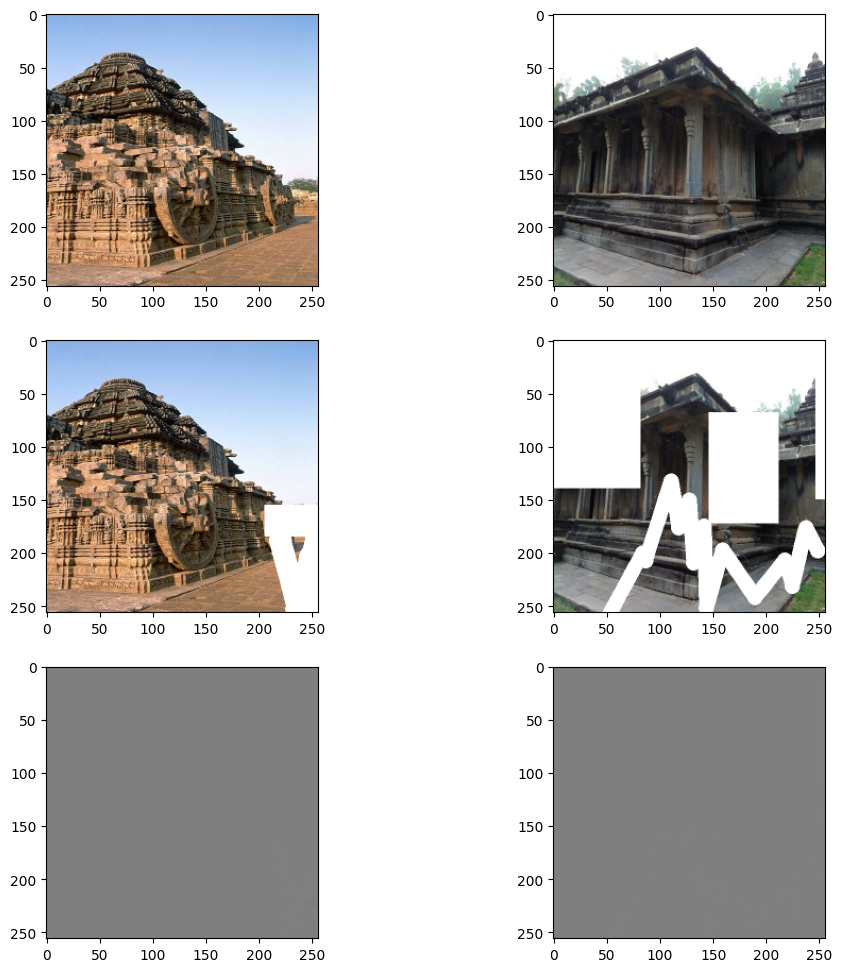

 92%|█████████▏| 138/150 [2:58:17<15:00, 75.00s/it, loss=loss:0.7635318040847778]

In [ ]:
G=train()

In [ ]:
print(mse_loss,psnr_loss,ssim_loss)

In [ ]:
G=tf.keras.models.load_model('/content/drive/MyDrive/model/model')

In [ ]:
import tensorflow as tf
model_path = "/content/drive/MyDrive/model/model"
model = tf.saved_model.load(model_path)

In [ ]:
x = cv2.imread("/content/drive/MyDrive/inpaint_main_data/data/test_data/1000.jpg")
mask = cv2.imread("/content/drive/MyDrive/inpaint_main_data/masks/test_masks/1004.jpg")
x = cv2.resize(x,(256,256))
mask = cv2.resize(mask,(256,256))
print(x.shape)
x_t = tf.convert_to_tensor(x)
mask_t = tf.convert_to_tensor(mask)

print(x_t.shape)
x_masked= x_t*mask_t+(1-mask_t)
x_pred=model([x_masked,mask_t],training=False)


In [ ]:
pth = "/content/drive/MyDrive/inpaint_main_data/data"
pth_mask = "/content/drive/MyDrive/inpaint_main_data/masks"
test_folder=sorted(os.listdir(f'{pth}/test_data'))
test_mask_folder=sorted(os.listdir(f'{pth_mask}/test_masks'))
df_test=pd.DataFrame(np.vstack([test_folder,test_mask_folder]).T,columns=['pth','pth_mask'])
df_test['pth']=df_test['pth'].apply(lambda x: os.path.join(f'{pth}/test_data/{x}'))
df_test['pth_mask']=df_test['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/test_masks/{x}'))

In [ ]:
ds_test=tf.data.Dataset.from_tensor_slices((df_test['pth'],df_test['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        batch(batch_size,drop_remainder=True)

In [ ]:
print(type(ds_test))

In [ ]:
for x,mask in ds_test:
  print(type(x))
  show(x,mask,model)

In [ ]:
x = "/content/drive/MyDrive/inpaint_main_data/data/test_data/1000.jpg"
mask = "/content/drive/MyDrive/inpaint_main_data/masks/test_masks/1004.jpg"

In [ ]:
x_t,mask_t = get_image(x,mask)
print(type(x_t))
x_masked = x_t*mask_t +(1-mask_t)
plt.imshow(x_masked)
#mask_t = tf.concat([mask_t for _ in range(3)], -1)
x_pred=model(x_masked,training=False)
#x_masked= x_t*mask_t+(1-mask_t)

#x_pred=model([x_masked,mask_t],training=False)
#mask = tf.concat([mask for _ in range(3)], -1)




In [ ]:
plt.imshow(x_pred)

In [ ]:
pth = "/content/drive/MyDrive/pred"
pth_mask = "/content/drive/MyDrive/pred"
test_folder=sorted(os.listdir(f'{pth}/pred_images'))
test_mask_folder=sorted(os.listdir(f'{pth_mask}/pred_masks'))
df_test=pd.DataFrame(np.vstack([test_folder,test_mask_folder]).T,columns=['pth','pth_mask'])
df_test['pth']=df_test['pth'].apply(lambda x: os.path.join(f'{pth}/pred_images/{x}'))
df_test['pth_mask']=df_test['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/pred_masks/{x}'))

In [ ]:
ds_test=tf.data.Dataset.from_tensor_slices((df_test['pth'],df_test['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        batch(2,drop_remainder=True)
print(ds_test)

In [ ]:
for x,mask in ds_test:
  print(type(x))

  show(x,mask,model)

In [ ]:
pth = "/content/drive/MyDrive/pred"
pth_mask = "/content/drive/MyDrive/pred"
test_folder=sorted(os.listdir(f'{pth}/pred_images'))
test_mask_folder=sorted(os.listdir(f'{pth_mask}/pred_masks'))
df_test=pd.DataFrame(np.vstack([test_folder,test_mask_folder]).T,columns=['pth','pth_mask'])
df_test['pth']=df_test['pth'].apply(lambda x: os.path.join(f'{pth}/pred_images/{x}'))
df_test['pth_mask']=df_test['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/pred_masks/{x}'))

In [ ]:
ds_test=tf.data.Dataset.from_tensor_slices((df_test['pth'],df_test['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        batch(2,drop_remainder=True)
print(ds_test)

In [ ]:
for x,mask in ds_test:
  print(type(x))

  show(x,mask,model)

In [ ]:
pth = "/content/drive/MyDrive/pred"
pth_mask = "/content/drive/MyDrive/pred"
test_folder=sorted(os.listdir(f'{pth}/try1'))
test_mask_folder=sorted(os.listdir(f'{pth_mask}/white_mask'))
df_test=pd.DataFrame(np.vstack([test_folder,test_mask_folder]).T,columns=['pth','pth_mask'])
df_test['pth']=df_test['pth'].apply(lambda x: os.path.join(f'{pth}/try1/{x}'))
df_test['pth_mask']=df_test['pth_mask'].apply(lambda x: os.path.join(f'{pth_mask}/white_mask/{x}'))

In [ ]:
ds_test=tf.data.Dataset.from_tensor_slices((df_test['pth'],df_test['pth_mask'])).map(get_image,num_parallel_calls=AUTOTUNE).\
                        batch(2,drop_remainder=True)
print(ds_test)

In [ ]:
for x,mask in ds_test:
  print(type(x))

  show(x,mask,model)

In [ ]:
converter=tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/model")
converter.optimizations=[tf.lite.Optimize.DEFAULT]
quantmodel=converter.convert()
with open("/content/drive/MyDrive/model.tflite","wb")as f:
  f.write(quantmodel)


In [ ]:
import numpy as np
import tensorflow as tf
import keras as ks
import matplotlib.pyplot as plt
import cv2
import os
import sklearn